## Prediction of Breast Cancer 

https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data 

Using the Breast Cancer Wisconsin (Diagnostic) Database, we can create a classifier that can help diagnose patients and predict the likelihood of a breast cancer. A few machine learning techniques will be explored.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import time
import warnings
import seaborn as sns

## Exploratory analysis

Load the dataset and do some quick exploratory analysis.

In [2]:
data = pd.read_csv("C:\\Users\\dell\\Desktop\\data.csv", index_col=False)
data.head(10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN
5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,NaN
6,844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,NaN
7,84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,NaN
8,844981,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,NaN
9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,NaN


In [3]:
print(data.shape)

(569, 33)


## Data visualisation and pre-processing

First thing to do is to enumerate the diagnosis column such that M = 1, B = 0. Then, I set the ID column to be the index of the dataframe. Afterall, the ID column will not be used for machine learning

In [4]:
data['diagnosis'] = data['diagnosis'].apply(lambda x: '1' if x == 'M' else '0')
data = data.set_index('id')
del data['Unnamed: 32']

Let's take a look at the number of Benign and Maglinant cases from the dataset. From the output shown below, majority of the cases are benign (0).

In [5]:
print(data.groupby('diagnosis').size())

diagnosis
0    357
1    212
dtype: int64


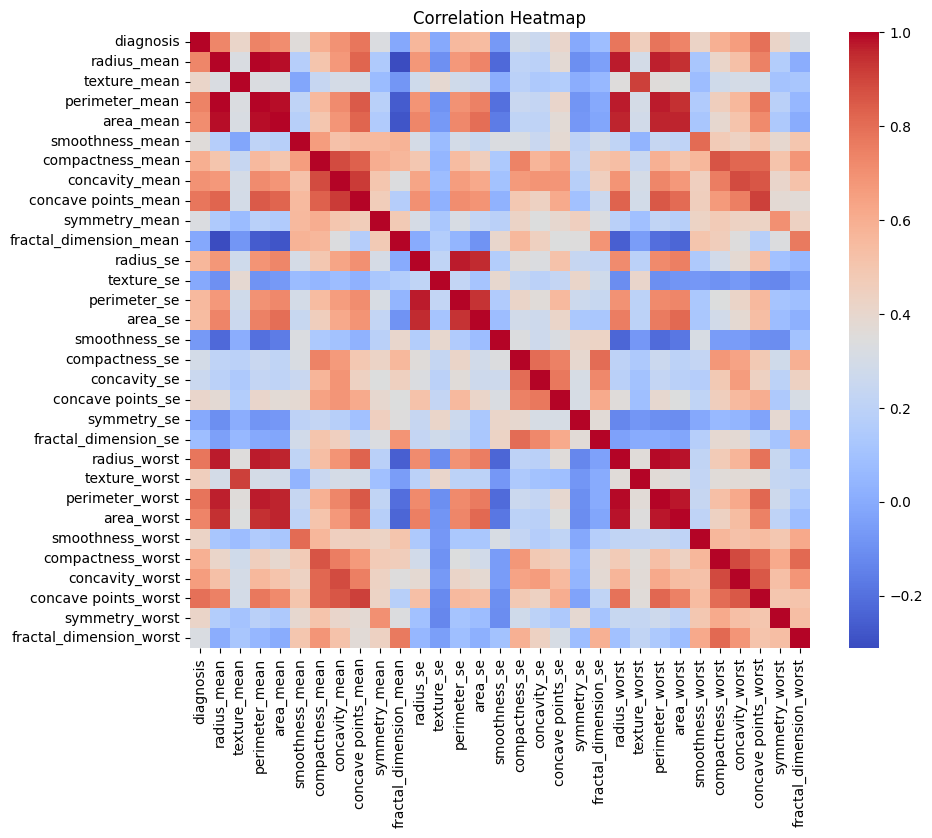

In [6]:
corr_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, fmt='.2f', cmap='coolwarm', xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)
plt.title('Correlation Heatmap')
plt.show()

It is good to check the correlations between the attributes. From the output graph below, The red around
the diagonal suggests that attributes are correlated with each other. The yellow and green patches suggest some moderate correlation and the blue boxes show negative correlations. 

Finally, we'll split the data into predictor variables and target variable, following by breaking them into train and test sets. We will use 20% of the data as test set.

In [7]:
Y = data['diagnosis'].values # target variable ---> predicted value 
X = data.drop('diagnosis', axis=1).values

X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size = 0.2, random_state=21)

## Baseline algorithm checking

From the dataset, we will analysis and build a model to predict if a given set of symptoms lead to breast cancer. This is a binary classification problem, and a few algorithms are appropriate for use. Since we do not know which one will perform the best at the point, we will do a quick test on the few appropriate algorithms with default setting to get an early indication of how each of them perform. We will use 10 fold cross validation for each testing.

The following non-linear algorithms will be used, namely: **Classification and Regression Trees (CART)**, **Linear Support Vector Machines (SVM)**, **Gaussian Naive Bayes (NB)** and **k-Nearest Neighbors (KNN)**.

In [8]:
models_list =  []
models_list.append(('CART', DecisionTreeClassifier()))
models_list.append(('SVM', SVC())) 
models_list.append(('NB', GaussianNB()))
models_list.append(('KNN', KNeighborsClassifier()))

In [9]:
num_folds = 10 
results = []
names = []

for name, model in models_list:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)

    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')

    results.append(cv_results)
    names.append(name)
    print("%s: %f" % (name, cv_results.mean()))


CART: 0.929517
SVM: 0.918502
NB: 0.940676
KNN: 0.934010


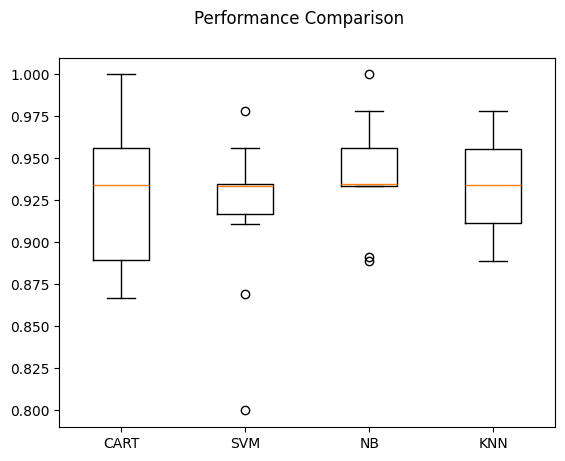

In [10]:
fig = plt.figure()
fig.suptitle('Performance Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Accuracy: Measures overall correctness.
### Precision: Focuses on the correctness of positive predictions, important when false positives are costly.
### Recall: Focuses on capturing all actual positives, important when false negatives are costly.
### F1 Score: Balances precision and recall, useful when the class distribution is uneven and you need a single metric that considers both false positives and false negatives.

### Macro Average: The average of the precision, recall, and F1-score across all classes.
### Weighted Average: The average of the precision, recall, and F1-score, weighted by the number of true instances for each class.
### Support: The number of actual occurrences of the class in the dataset.

# 1 --> عندو المرض positive M
# 0 --> معندوش negative B
# PERCISION INCREASE ---> FP DECREASE 
# RECALL INCREASE ---> FN DECREASE

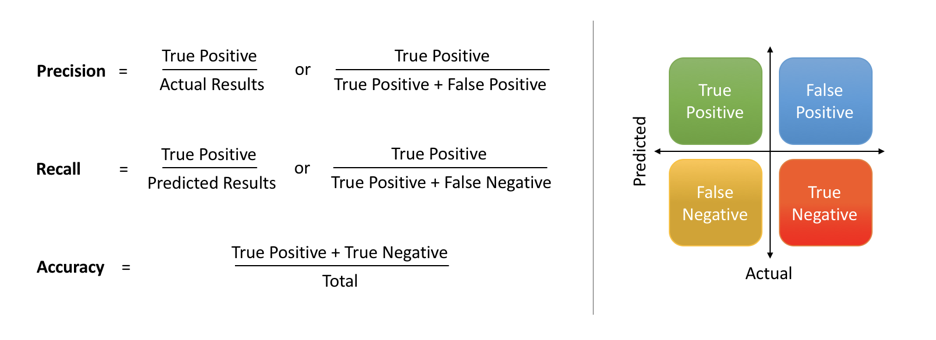
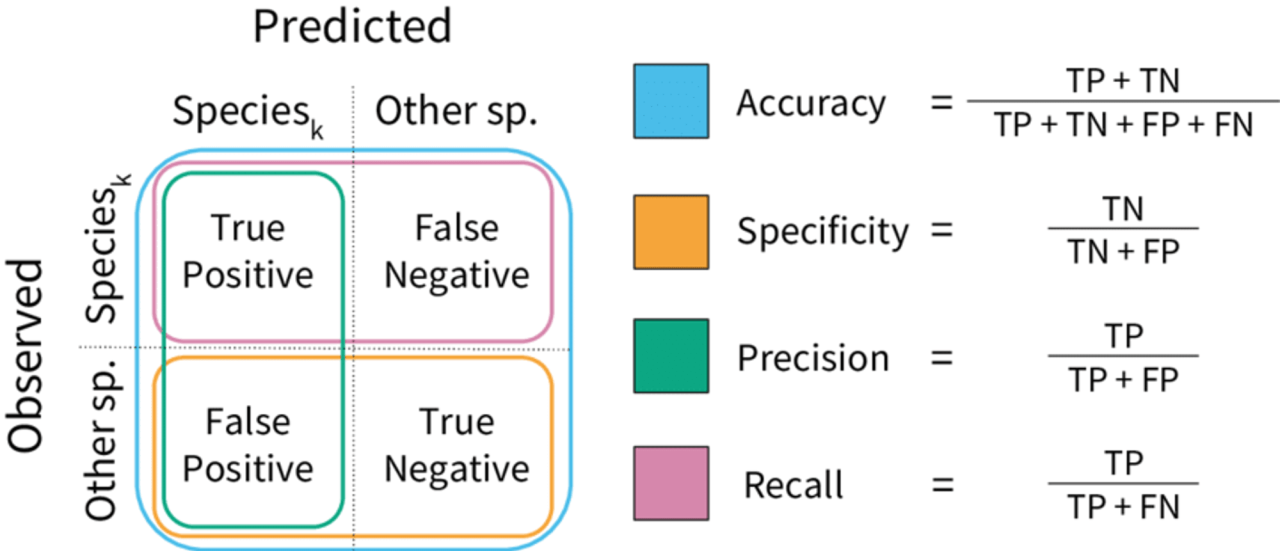

# SVM Model with Cross-Validation

In [13]:
# Importing necessary libraries for SVM
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# Define the SVM model
svm_model = SVC()

# Using cross-validation to evaluate the SVM model

kfold = KFold(n_splits=10, shuffle=True, random_state=1)
cv_results = cross_val_score(svm_model, X_train, Y_train, cv=kfold, scoring='accuracy')

# Printing the mean accuracy from cross-validation
print(f"SVM Cross-Validation Accuracy: {cv_results.mean()}")

# Train the model on the entire training set and evaluate on the test set
svm_model.fit(X_train, Y_train)
Y_pred = svm_model.predict(X_test)
print(f"Test Set Accuracy: {accuracy_score(Y_test, Y_pred)}")
print(f"Confusion Matrix:\n{confusion_matrix(Y_test, Y_pred)}")
print(f"Classification Report:\n{classification_report(Y_test, Y_pred)}")


SVM Cross-Validation Accuracy: 0.9185024154589373
Test Set Accuracy: 0.8859649122807017
Confusion Matrix:
[[73  2]
 [11 28]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92        75
           1       0.93      0.72      0.81        39

    accuracy                           0.89       114
   macro avg       0.90      0.85      0.86       114
weighted avg       0.89      0.89      0.88       114



# Using Specific Features for Prediction with Cross-Validation

In [15]:
# Selecting specific features for prediction
selected_features = ['radius_mean', 'perimeter_mean', 'concave points_mean']
X_selected = data[selected_features].values
Y_selected = data['diagnosis'].values

# Splitting the data
X_train_sel, X_test_sel, Y_train_sel, Y_test_sel = train_test_split(X_selected, Y_selected, test_size=0.2, random_state=21)

# Define the SVM model
svm_model_sel = SVC()

# Using cross-validation to evaluate the SVM model with selected features
cv_results_sel = cross_val_score(svm_model_sel, X_train_sel, Y_train_sel, cv=kfold, scoring='accuracy')

# Printing the mean accuracy from cross-validation with selected features
print(f"SVM Cross-Validation Accuracy with selected features: {cv_results_sel.mean()}")

# Train the model on the entire training set with selected features and evaluate on the test set
svm_model_sel.fit(X_train_sel, Y_train_sel)
Y_pred_sel = svm_model_sel.predict(X_test_sel)
print(f"Test Set Accuracy with selected features: {accuracy_score(Y_test_sel, Y_pred_sel)}")
print(f"Confusion Matrix:\n{confusion_matrix(Y_test_sel, Y_pred_sel)}")
print(f"Classification Report:\n{classification_report(Y_test_sel, Y_pred_sel)}")


SVM Cross-Validation Accuracy with selected features: 0.8943478260869565
Test Set Accuracy with selected features: 0.8771929824561403
Confusion Matrix:
[[72  3]
 [11 28]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91        75
           1       0.90      0.72      0.80        39

    accuracy                           0.88       114
   macro avg       0.89      0.84      0.86       114
weighted avg       0.88      0.88      0.87       114



# Decision Tree Classifier with Cross-Validation

In [16]:
# Importing necessary libraries for Decision Tree
from sklearn.tree import DecisionTreeClassifier

# Define the Decision Tree model
cart_model = DecisionTreeClassifier()

# Using cross-validation to evaluate the Decision Tree model
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
cv_results_cart = cross_val_score(cart_model, X_train, Y_train, cv=kfold, scoring='accuracy')

# Printing the mean accuracy from cross-validation
print(f"CART Cross-Validation Accuracy: {cv_results_cart.mean()}")

# Train the model on the entire training set and evaluate on the test set
cart_model.fit(X_train, Y_train)
Y_pred_cart = cart_model.predict(X_test)
print(f"Test Set Accuracy: {accuracy_score(Y_test, Y_pred_cart)}")
print(f"Confusion Matrix:\n{confusion_matrix(Y_test, Y_pred_cart)}")
print(f"Classification Report:\n{classification_report(Y_test, Y_pred_cart)}")


CART Cross-Validation Accuracy: 0.9142028985507247
Test Set Accuracy: 0.9298245614035088
Confusion Matrix:
[[71  4]
 [ 4 35]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        75
           1       0.90      0.90      0.90        39

    accuracy                           0.93       114
   macro avg       0.92      0.92      0.92       114
weighted avg       0.93      0.93      0.93       114



# Using Specific Features for Prediction with Cross-Validation

In [18]:
# Selecting specific features for prediction
selected_features = ['radius_mean', 'perimeter_mean', 'concave points_mean']
X_selected = data[selected_features].values
Y_selected = data['diagnosis'].values

# Splitting the data
X_train_sel, X_test_sel, Y_train_sel, Y_test_sel = train_test_split(X_selected, Y_selected, test_size=0.2, random_state=21)

# Define the Decision Tree model
cart_model_sel = DecisionTreeClassifier()

# Using cross-validation to evaluate the Decision Tree model with selected features
cv_results_cart_sel = cross_val_score(cart_model_sel, X_train_sel, Y_train_sel, cv=kfold, scoring='accuracy')

# Printing the mean accuracy from cross-validation with selected features
print(f"CART Cross-Validation Accuracy with selected features: {cv_results_cart_sel.mean()}")

# Train the model on the entire training set with selected features and evaluate on the test set
cart_model_sel.fit(X_train_sel, Y_train_sel)
Y_pred_cart_sel = cart_model_sel.predict(X_test_sel)
print(f"Test Set Accuracy with selected features: {accuracy_score(Y_test_sel, Y_pred_cart_sel)}")
print(f"Confusion Matrix:\n{confusion_matrix(Y_test_sel, Y_pred_cart_sel)}")
print(f"Classification Report:\n{classification_report(Y_test_sel, Y_pred_cart_sel)}")


CART Cross-Validation Accuracy with selected features: 0.8855555555555554
Test Set Accuracy with selected features: 0.868421052631579
Confusion Matrix:
[[68  7]
 [ 8 31]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90        75
           1       0.82      0.79      0.81        39

    accuracy                           0.87       114
   macro avg       0.86      0.85      0.85       114
weighted avg       0.87      0.87      0.87       114



# Gaussian Naive Bayes with Cross-Validation

In [19]:
# Importing necessary libraries for Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Define the Gaussian Naive Bayes model
nb_model = GaussianNB()

# Using cross-validation to evaluate the Gaussian Naive Bayes model
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
cv_results_nb = cross_val_score(nb_model, X_train, Y_train, cv=kfold, scoring='accuracy')

# Printing the mean accuracy from cross-validation
print(f"NB Cross-Validation Accuracy: {cv_results_nb.mean()}")

# Train the model on the entire training set and evaluate on the test set
nb_model.fit(X_train, Y_train)
Y_pred_nb = nb_model.predict(X_test)
print(f"Test Set Accuracy: {accuracy_score(Y_test, Y_pred_nb)}")
print(f"Confusion Matrix:\n{confusion_matrix(Y_test, Y_pred_nb)}")
print(f"Classification Report:\n{classification_report(Y_test, Y_pred_nb)}")


NB Cross-Validation Accuracy: 0.9406763285024156
Test Set Accuracy: 0.9210526315789473
Confusion Matrix:
[[72  3]
 [ 6 33]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        75
           1       0.92      0.85      0.88        39

    accuracy                           0.92       114
   macro avg       0.92      0.90      0.91       114
weighted avg       0.92      0.92      0.92       114



# Using Specific Features for Prediction with Cross-Validation

In [21]:
# Selecting specific features for prediction
selected_features = ['radius_mean', 'perimeter_mean', 'concave points_mean']
X_selected = data[selected_features].values
Y_selected = data['diagnosis'].values

# Splitting the data
X_train_sel, X_test_sel, Y_train_sel, Y_test_sel = train_test_split(X_selected, Y_selected, test_size=0.2, random_state=21)

# Define the Gaussian Naive Bayes model
nb_model_sel = GaussianNB()

# Using cross-validation to evaluate the Gaussian Naive Bayes model with selected features
cv_results_nb_sel = cross_val_score(nb_model_sel, X_train_sel, Y_train_sel, cv=kfold, scoring='accuracy')

# Printing the mean accuracy from cross-validation with selected features
print(f"NB Cross-Validation Accuracy with selected features: {cv_results_nb_sel.mean()}")

# Train the model on the entire training set with selected features and evaluate on the test set
nb_model_sel.fit(X_train_sel, Y_train_sel)
Y_pred_nb_sel = nb_model_sel.predict(X_test_sel)
print(f"Test Set Accuracy with selected features: {accuracy_score(Y_test_sel, Y_pred_nb_sel)}")
print(f"Confusion Matrix:\n{confusion_matrix(Y_test_sel, Y_pred_nb_sel)}")
print(f"Classification Report:\n{classification_report(Y_test_sel, Y_pred_nb_sel)}")


NB Cross-Validation Accuracy with selected features: 0.9141545893719807
Test Set Accuracy with selected features: 0.9122807017543859
Confusion Matrix:
[[70  5]
 [ 5 34]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        75
           1       0.87      0.87      0.87        39

    accuracy                           0.91       114
   macro avg       0.90      0.90      0.90       114
weighted avg       0.91      0.91      0.91       114



# K-Nearest Neighbors with Cross-Validation

In [22]:
# Importing necessary libraries for K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

# Define the K-Nearest Neighbors model
knn_model = KNeighborsClassifier()

# Using cross-validation to evaluate the K-Nearest Neighbors model
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
cv_results_knn = cross_val_score(knn_model, X_train, Y_train, cv=kfold, scoring='accuracy')

# Printing the mean accuracy from cross-validation
print(f"KNN Cross-Validation Accuracy: {cv_results_knn.mean()}")

# Train the model on the entire training set and evaluate on the test set
knn_model.fit(X_train, Y_train)
Y_pred_knn = knn_model.predict(X_test)
print(f"Test Set Accuracy: {accuracy_score(Y_test, Y_pred_knn)}")
print(f"Confusion Matrix:\n{confusion_matrix(Y_test, Y_pred_knn)}")
print(f"Classification Report:\n{classification_report(Y_test, Y_pred_knn)}")


KNN Cross-Validation Accuracy: 0.9340096618357489
Test Set Accuracy: 0.9210526315789473
Confusion Matrix:
[[72  3]
 [ 6 33]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        75
           1       0.92      0.85      0.88        39

    accuracy                           0.92       114
   macro avg       0.92      0.90      0.91       114
weighted avg       0.92      0.92      0.92       114



# Using Specific Features for Prediction with Cross-Validation

In [24]:
# Selecting specific features for prediction
selected_features = ['radius_mean', 'perimeter_mean', 'concave points_mean']
X_selected = data[selected_features].values
Y_selected = data['diagnosis'].values

# Splitting the data
X_train_sel, X_test_sel, Y_train_sel, Y_test_sel = train_test_split(X_selected, Y_selected, test_size=0.2, random_state=21)

# Define the K-Nearest Neighbors model
knn_model_sel = KNeighborsClassifier()

# Using cross-validation to evaluate the K-Nearest Neighbors model with selected features
cv_results_knn_sel = cross_val_score(knn_model_sel, X_train_sel, Y_train_sel, cv=kfold, scoring='accuracy')

# Printing the mean accuracy from cross-validation with selected features
print(f"KNN Cross-Validation Accuracy with selected features: {cv_results_knn_sel.mean()}")

# Train the model on the entire training set with selected features and evaluate on the test set
knn_model_sel.fit(X_train_sel, Y_train_sel)
Y_pred_knn_sel = knn_model_sel.predict(X_test_sel)
print(f"Test Set Accuracy with selected features: {accuracy_score(Y_test_sel, Y_pred_knn_sel)}")
print(f"Confusion Matrix:\n{confusion_matrix(Y_test_sel, Y_pred_knn_sel)}")
print(f"Classification Report:\n{classification_report(Y_test_sel, Y_pred_knn_sel)}")


KNN Cross-Validation Accuracy with selected features: 0.8810144927536232
Test Set Accuracy with selected features: 0.8859649122807017
Confusion Matrix:
[[71  4]
 [ 9 30]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92        75
           1       0.88      0.77      0.82        39

    accuracy                           0.89       114
   macro avg       0.88      0.86      0.87       114
weighted avg       0.89      0.89      0.88       114

